<a href="https://colab.research.google.com/github/yashghogre/Backprop-From-Scratch/blob/main/grad_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [ ]:
def f(x):
    return (5*x**2 - 4*x + 1)

In [ ]:
X = np.arange(-4, 4, 0.25)
y = f(X)

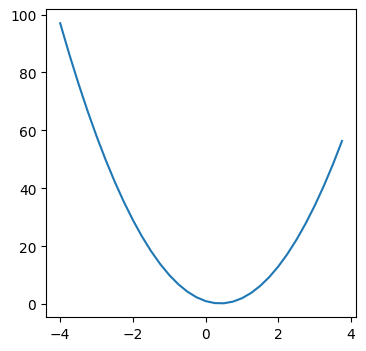

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(X, y)

In [ ]:
class drop:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.00
        self.label = label
        self._backward = lambda: None

    def __add__(self, other):
        other = other if isinstance(other, drop) else drop(other)
        out = drop(self.data + other.data, _children=(self, other), _op="+")
        # out._prev(self, other)

        def _backward():
          self.grad += 1.0*out.grad
          other.grad += 1.0*out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, drop) else drop(other)
        out = drop(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
          self.grad += out.grad * other.data
          other.grad += out.grad * self.data

        out._backward = _backward

        return out

    def __sub__(self, other):
        out = drop(self.data-other.data, _children=(self, other), _op="-")
        return out

    def __div__(self, other):
        out = drop(self.data/other.data, _children=(self, other), _op="/")
        return out

    def __rmul__(self, other):
      return self*other

    def __radd__(self, other):
      return self+other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = drop(t, (self, ), _op="tanh")

        def _backward():
          self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
      topo = []
      visited = set()

      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)
      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

    def __repr__(self):
        return f"(drop: {self.data})"

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
### Trying small operations
## First Forward Propagation and Initialization

a = drop(2, label="a")
b = drop(-4, label="b")
c = drop(5, label="c")
d = a*b; d.label="d"
e = d+c; e.label="e"

f = drop(6, label="f")
g = drop(1, label="g")
h = e*f; h.label="h"
i = h+g; i.label="i"
j = i.tanh(); label="j"
j

(drop: -0.9999999999999966)

In [ ]:
## Back propagation

i.grad = 1
g.grad = 1
h.grad = 1
f.grad = h.grad*e.data
e.grad = h.grad*f.data
c.grad = e.grad
d.grad = e.grad
a.grad = d.grad*b.data
b.grad = d.grad*a.data

d.label

'd'

In [ ]:
## Gradient Descent

lr = 0.01

a.data += lr*a.grad
b.data += lr*b.grad
c.data += lr*c.grad
f.data += lr*f.grad
g.data += lr*g.grad

d.label

'd'

In [ ]:
## Forward Propagation

d = a*b
e = d+c
h = e*f
i = h+g
i = i.tanh()
i

d.label

''

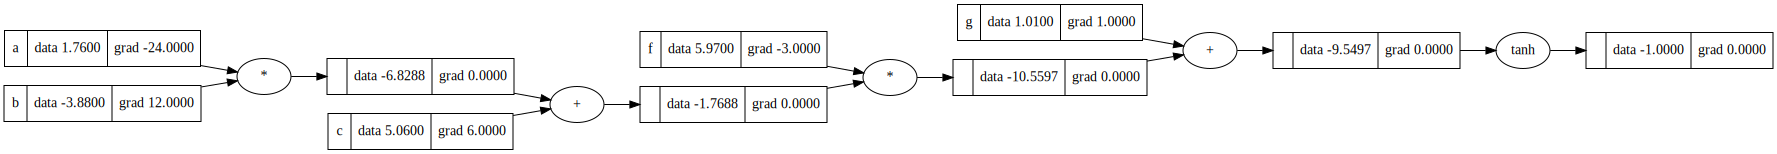

In [ ]:
draw_dot(i)

Now let's see some bigger and good examples

In [ ]:
# Inputs
x1 = drop(2, label="x1")
x2 = drop(1, label="x2")

# Weights
w1 = drop(-3, label="w1")
w2 = drop(2, label="w2")

# Bias
b = drop(3, label="b")

# Calculation and finding equation
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

In [ ]:
o.backward()

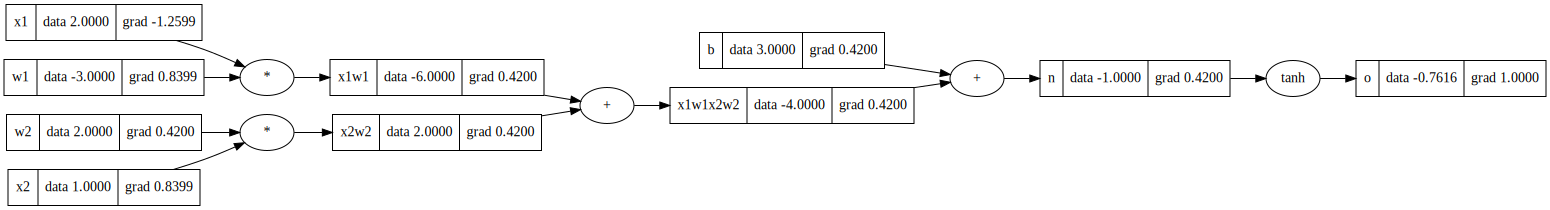

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward() ## should have no effect on any grads

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
a = drop(2.0)
2+a

(drop: 4.0)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [drop(random.uniform(-1, 1) for _ in range(nin))]       ## Here nin is the number of input arrows on each neuron
    self.b = drop(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]                ## nout is the number of neurons in the layer

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:
  def __init__(self, nin, nouts):                                    ## nin is the number of input for neurons and nouts is the list of number of neurons in each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
x = [2.0, 4.0, 1.0]

n = MLP(3, [4, 4, 1])
n(x)

TypeError: unsupported operand type(s) for *: 'generator' and 'float'

In [ ]:
draw_dot(n(x))

TypeError: unsupported operand type(s) for *: 'generator' and 'float'